# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
torch.manual_seed(0) # setting random seed

# Augmenting train data by random cropping and flipping (also helped with overfitting)
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# - Feedback also suggested trying other augmentations, such as ColorJitter and RandomAffine

# No augmenting for test set
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True,
                                        train=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create test set
test_data = torchvision.datasets.CIFAR10('CIFAR10_data/', download=True,
                                        train=False, transform=test_transform)

# Generate validation set from part of test data (Source: https://stackoverflow.com/a/51768651 and feedback)
test_size = int(len(test_data) * 0.8) # 80% testing data
valid_size = len(test_data) - test_size # 20% validation data
test_data, valid_data = torch.utils.data.random_split(test_data, [test_size, valid_size])

# Define test and validation dataloaders
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
# With some modifications based on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# and improved to more compact output based on feedback

def show5(img_loader):
    batch = next(iter(img_loader))
    labels = batch[1][0:5]
    images = batch[0][0:5]
    fig = plt.figure(figsize=(10,4))
    
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        image = images[i].numpy()
        image = image / 2 + 0.5 # unnormalize the images

        plt.imshow(np.rot90(image.T, k=3))
        ax.set_title(classes[labels[i]]) # set img label as plot title

In [4]:
# Exploring data size

# - Print number of training images
input_count = 0
for data in train_loader:
    inputs, labels = data
    input_count += labels.size(0)
 
print("Number of training images: {:,}".format(input_count))

# - Print number of validation images
input_count = 0
for data in valid_loader:
    inputs, labels = data
    input_count += labels.size(0)

print("Number of validation images: {:,}".format(input_count))

# - Print number of test images
input_count = 0
for data in test_loader:
    inputs, labels = data
    input_count += labels.size(0)
 
print("Number of test images: {:,}".format(input_count))

# - Print size of image(s)
batch = next(iter(train_loader))
image = batch[0][0][0:1]
print('Image size: {}x{} pixels'.format(image.size(1), image.size(2)))

Number of training images: 50,000
Number of validation images: 2,000
Number of test images: 8,000
Image size: 32x32 pixels


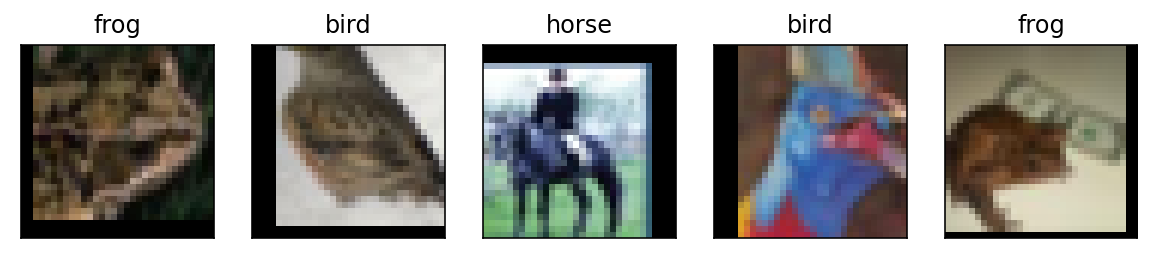

In [5]:
# Exploring training images

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
# Inspired and extended version (~70% to move over 70% accuracy) of PyTorch example
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# and class structure from more advanced model: https://zhenye-na.github.io/2018/09/28/pytorch-cnn-cifar10.html

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layer (added one sublayer)
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )

        # Fully Connected layer (added one sublayer)
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=10)          
        )
            
    def forward(self, x):
        # Convolutional layer
        x = self.conv_layer(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch, old versions x = x.view(x.size(0), -1)

        # Fully Connected layer
        x = self.fc_layer(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
model = Classifier()

# Cross Entropy loss function
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent optimizer (seemed to work a bit better than Adam)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.003)

# Scheduler (adjusts learning rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

# Nice summary of model based on feedback (updated to new package name)
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               --                        --
├─Sequential: 1-1                        [32, 32, 4, 4]            --
│    └─Conv2d: 2-1                       [32, 6, 28, 28]           456
│    └─ReLU: 2-2                         [32, 6, 28, 28]           --
│    └─Conv2d: 2-3                       [32, 16, 24, 24]          2,416
│    └─MaxPool2d: 2-4                    [32, 16, 12, 12]          --
│    └─Conv2d: 2-5                       [32, 32, 8, 8]            12,832
│    └─MaxPool2d: 2-6                    [32, 32, 4, 4]            --
├─Sequential: 1-2                        [32, 10]                  --
│    └─Linear: 2-7                       [32, 256]                 131,328
│    └─ReLU: 2-8                         [32, 256]                 --
│    └─Linear: 2-9                       [32, 128]                 32,896
│    └─ReLU: 2-10                        [32, 128]                 -

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Most content from course exercise content, but updated the statistics calculation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Running on", device)

model.to(device) # Transfer model to default device

epochs = 100 # Set how many epocs you want to run
running_loss = 0

train_losses, valid_losses, valid_accuracy = [], [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Transfer images and labels to default device
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    scheduler.step()

    # Calculate training and validation statistics
    valid_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        # Calculate validation values
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
                    
            valid_loss += batch_loss.item()
                    
            # Calculate validation accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Save values
        train_losses.append(running_loss / len(train_loader))
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracy.append(accuracy / len(valid_loader))

        print(f"Epoch: {epoch+1:>3}/{epochs:>3} "
            f"Train loss: {running_loss / len(train_loader):.3f} "
            f"Validation loss: {valid_loss / len(valid_loader):.3f} "
            f"Validation accuracy: {100 * accuracy / len(valid_loader):.2f}%")

        running_loss = 0
        model.train()

print('Finished Training')

Running on cpu
Epoch:   1/100 Train loss: 1.892 Validation loss: 1.565 Validation accuracy: 42.51%
Epoch:   2/100 Train loss: 1.571 Validation loss: 1.449 Validation accuracy: 48.12%
Epoch:   3/100 Train loss: 1.440 Validation loss: 1.324 Validation accuracy: 52.23%
Epoch:   4/100 Train loss: 1.336 Validation loss: 1.297 Validation accuracy: 53.17%
Epoch:   5/100 Train loss: 1.251 Validation loss: 1.172 Validation accuracy: 58.78%
Epoch:   6/100 Train loss: 1.173 Validation loss: 1.139 Validation accuracy: 60.91%
Epoch:   7/100 Train loss: 1.116 Validation loss: 1.037 Validation accuracy: 64.24%
Epoch:   8/100 Train loss: 1.065 Validation loss: 1.055 Validation accuracy: 63.19%
Epoch:   9/100 Train loss: 1.028 Validation loss: 0.993 Validation accuracy: 64.68%
Epoch:  10/100 Train loss: 0.989 Validation loss: 0.957 Validation accuracy: 67.06%
Epoch:  11/100 Train loss: 0.957 Validation loss: 0.994 Validation accuracy: 67.36%
Epoch:  12/100 Train loss: 0.928 Validation loss: 0.924 Valid

Epoch:  99/100 Train loss: 0.641 Validation loss: 0.715 Validation accuracy: 75.20%
Epoch: 100/100 Train loss: 0.637 Validation loss: 0.715 Validation accuracy: 75.15%
Finished Training


Plot the training loss (and validation loss/accuracy, if recorded).

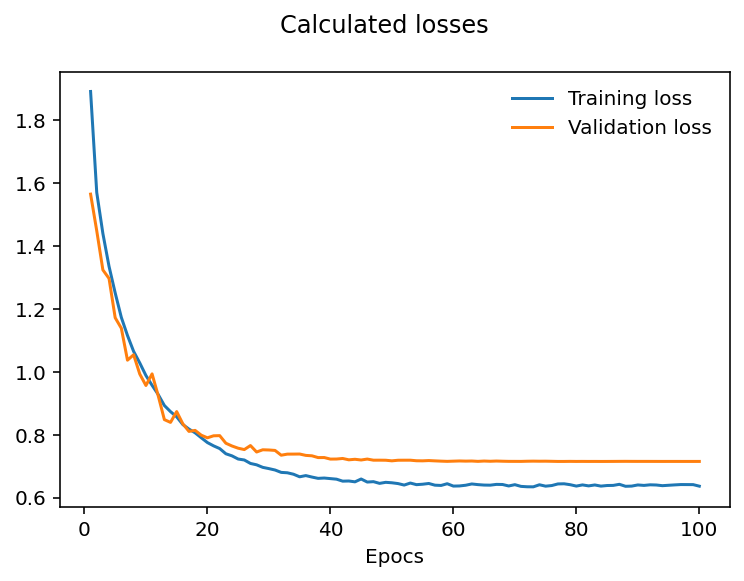

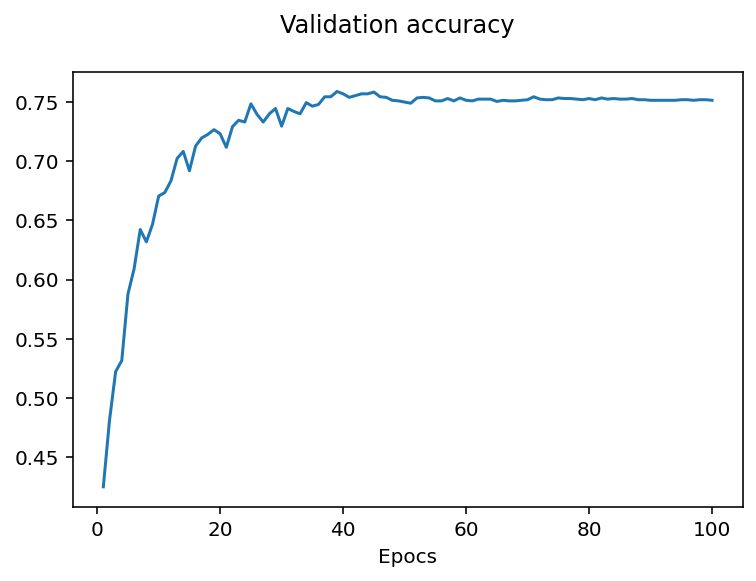

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.suptitle('Calculated losses')
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation loss')
plt.xlabel('Epocs')
plt.legend(frameon=False)
plt.show()

plt.suptitle('Validation accuracy')
plt.plot(range(1,len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('Epocs')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
# Original source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0

input_count = 0
with torch.no_grad(): # no gradient calculation since not training
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # Transfer images and labels to default device
        # Calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        input_count += labels.size(0)
        
print("Accuracy of the network on the {:,} test images: {:.2f}%".format(input_count, (100 * correct / total)))

Accuracy of the network on the 8,000 test images: 76.33%


In [12]:
# Original source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad(): # no gradient calculation since not training
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # Transfer images and labels to default device
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
print("Accuracy for each class:")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("- Class {:5s} {:.2f}%".format(classname, accuracy))

Accuracy for each class:
- Class plane 79.60%
- Class car   89.10%
- Class bird  66.67%
- Class cat   53.20%
- Class deer  74.13%
- Class dog   64.50%
- Class frog  85.77%
- Class horse 80.92%
- Class ship  85.31%
- Class truck 83.57%


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Updated for full checkpoint (including optimizer and scheduler) based on feedback

full_checkpoint = {'state_dict':model.state_dict(),
                   'optim_dict':optimizer.state_dict(),
                   'scheduler': scheduler,
                   'epoch':epoch}

torch.save(full_checkpoint, 'full_checkpoint.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I have built an image classifier using a neural network model in PyTorch. I trained the model using the CIFAR-10 dataset, and in testing the model achieved a 76.3% accuracy rate. The result is 9.0% better than Detectocorp's algorithm which has a 70% accuracy rate for the same dataset. And our model has still much room for improvement. Thus, I would recommend building an in-house solution.